In [3]:
import warnings
warnings.filterwarnings("ignore")
import joblib
import gc
import multiprocessing as mp
import numpy as np
import pandas as pd
import _pickle as cpickle
import seaborn as sns
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score,roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [4]:
# Importing features

user_df = pd.read_pickle(r'C:\Sanal\data_science_dreamjob\portfolio project\instacart-market-basket-analysis\user_df.pkl')
prd_df = pd.read_pickle(r'C:\Sanal\data_science_dreamjob\portfolio project\instacart-market-basket-analysis\prd_df.pkl')
user_x_product = pd.read_pickle(r'C:\Sanal\data_science_dreamjob\portfolio project\instacart-market-basket-analysis\user_x_product.pkl')

In [5]:
# importing csv files
orderprdtrain_df = pd.read_csv(r'C:\Sanal\data_science_dreamjob\portfolio project\instacart-market-basket-analysis\order_products__train.csv')
orders_df = pd.read_csv(r'C:\Sanal\data_science_dreamjob\portfolio project\instacart-market-basket-analysis\orders.csv')

In [6]:
orders_df['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [7]:
# feature files
user_df.head()

,max_orders,mean_orders,min_orders,max_day_of_week,max_order_hour_of_day,sum_days_since_prior_order,mean_days_since_prior_order,reordered_ratio,total_num_orders,user_total_prods,user_unique_prods,user_average_basket,user_order_starts_at,avg_no_prds_each_purchase,median_no_prds_each_purchase,min_no_prds_each_purchase,max_no_prds_each_purchase
user_id,,,,,,,,,,,,,,,,,
1,10,10,10,4,4,1149.5,19.483051,0.694915,343,59,18,0.172012,431534,5.900000,5.5,4,9
2,14,14,14,2,2,3050.3,15.642564,0.476923,1567,195,102,0.124442,738281,13.928571,13.5,5,26
3,12,12,12,0,0,1007.0,11.443182,0.625000,528,88,33,0.166667,444309,7.333333,7.0,5,11
4,5,5,5,4,4,259.4,14.411111,0.055556,52,18,17,0.346154,94891,3.600000,3.0,2,7
5,4,4,4,3,3,499.1,13.489189,0.378378,92,37,23,0.402174,157374,9.250000,10.0,5,12


In [8]:
prd_df.head()

,product_id,times_purchased,prod_tot_reorders,prod_reordered_ratio,avg_cart_position,median_cart_position,sum_cart_position,min_cart_position,max_cart_position,std_cart_position,aisle_reorder_ratio,department_reorder_ratio
0,1,1852,1136,0.613391,5.801836,4.0,10745,1,74,5.575389,0.548698,0.574180
1,2,90,12,0.133333,9.888889,8.0,890,1,45,7.821670,0.152391,0.346721
2,3,277,203,0.732852,6.415162,4.0,1777,1,41,6.472701,0.527615,0.653460
3,4,329,147,0.446809,9.507599,8.0,3128,1,36,6.861485,0.556655,0.541885
4,5,15,9,0.600000,6.466667,6.0,97,3,16,3.563038,0.280627,0.346721


In [9]:
user_x_product.head()

,user_id,product_id,times_brought,uxp_total_reordered,uxp_first_order_num,uxp_avg_cart_pos,uxp_min_cart_pos,uxp_max_cart_pos,uxp_median_cart_pos,uxp_last_order_num,uxp_avg_dow,uxp_median_dow,uxp_avg_hour_of_the_day,uxp_median_hour_of_the_day,uxp_order_rate,uxp_sum_cart_pos,uxp_min_order_days,uxp_max_order_days,uxp_median_order_days,uxp_reorder_ratio
0,1,196,10,9,1,1.400000,1,4,1.0,10,2.500000,2.5,10.300000,8.5,1.0,14,0.0,30.0,19.5,0.900000
1,1,10258,9,8,2,3.333333,2,6,3.0,10,2.555556,3.0,10.555556,9.0,0.9,30,0.0,30.0,20.0,0.888889
2,1,10326,1,0,5,5.000000,5,5,5.0,5,4.000000,4.0,15.000000,15.0,0.1,5,28.0,28.0,28.0,0.000000
3,1,12427,10,9,1,3.300000,1,9,2.5,10,2.500000,2.5,10.300000,8.5,1.0,33,0.0,30.0,19.5,0.900000
4,1,13032,3,2,2,6.333333,5,8,6.0,10,2.666667,3.0,8.000000,8.0,0.3,19,15.0,30.0,20.0,0.666667


# Merging products, users, user-product dataframes

In [10]:
# Merging user_x_product features with users features
data = user_x_product.merge(user_df, on='user_id', how='left')
data.head()

,user_id,product_id,times_brought,uxp_total_reordered,uxp_first_order_num,uxp_avg_cart_pos,uxp_min_cart_pos,uxp_max_cart_pos,uxp_median_cart_pos,uxp_last_order_num,...,reordered_ratio,total_num_orders,user_total_prods,user_unique_prods,user_average_basket,user_order_starts_at,avg_no_prds_each_purchase,median_no_prds_each_purchase,min_no_prds_each_purchase,max_no_prds_each_purchase
0,1,196,10,9,1,1.400000,1,4,1.0,10,...,0.694915,343,59,18,0.172012,431534,5.9,5.5,4,9
1,1,10258,9,8,2,3.333333,2,6,3.0,10,...,0.694915,343,59,18,0.172012,431534,5.9,5.5,4,9
2,1,10326,1,0,5,5.000000,5,5,5.0,5,...,0.694915,343,59,18,0.172012,431534,5.9,5.5,4,9
3,1,12427,10,9,1,3.300000,1,9,2.5,10,...,0.694915,343,59,18,0.172012,431534,5.9,5.5,4,9
4,1,13032,3,2,2,6.333333,5,8,6.0,10,...,0.694915,343,59,18,0.172012,431534,5.9,5.5,4,9


In [11]:
# Merging product features with data.
data = data.merge(prd_df, on='product_id', how='left')
data.head()

,user_id,product_id,times_brought,uxp_total_reordered,uxp_first_order_num,uxp_avg_cart_pos,uxp_min_cart_pos,uxp_max_cart_pos,uxp_median_cart_pos,uxp_last_order_num,...,prod_tot_reorders,prod_reordered_ratio,avg_cart_position,median_cart_position,sum_cart_position,min_cart_position,max_cart_position,std_cart_position,aisle_reorder_ratio,department_reorder_ratio
0,1,196,10,9,1,1.400000,1,4,1.0,10,...,27791,0.776480,3.721774,2.0,133206,1,60,4.110813,0.638832,0.653460
1,1,10258,9,8,2,3.333333,2,6,3.0,10,...,1389,0.713772,4.277492,3.0,8324,1,29,3.567502,0.519170,0.574180
2,1,10326,1,0,5,5.000000,5,5,5.0,5,...,3603,0.652009,4.191097,3.0,23160,1,37,3.611700,0.718104,0.649913
3,1,12427,10,9,1,3.300000,1,9,2.5,10,...,4797,0.740735,4.760037,3.0,30826,1,61,4.782450,0.591986,0.574180
4,1,13032,3,2,2,6.333333,5,8,6.0,10,...,2465,0.657158,5.622767,4.0,21091,1,66,5.345184,0.571584,0.560922


In [12]:
data.shape

(13307953, 48)

# Creating Train and Test Datasets

In [13]:
# Orders data
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [14]:
# future orders (train and test under eval_set)
future_orders = orders_df[((orders_df['eval_set'] == 'train') | (orders_df['eval_set'] == 'test'))]
future_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,train,11,4,8,14.0
25,1492625,2,train,15,1,11,30.0
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
49,2196797,5,train,5,0,11,6.0


In [15]:
future_orders = future_orders[['user_id', 'order_id', 'eval_set']]
future_orders.head()
future_orders.shape

(206209, 3)

In [16]:
#merging data with future orders
data = data.merge(future_orders, on='user_id', how='left')
data.head()

,user_id,product_id,times_brought,uxp_total_reordered,uxp_first_order_num,uxp_avg_cart_pos,uxp_min_cart_pos,uxp_max_cart_pos,uxp_median_cart_pos,uxp_last_order_num,...,avg_cart_position,median_cart_position,sum_cart_position,min_cart_position,max_cart_position,std_cart_position,aisle_reorder_ratio,department_reorder_ratio,order_id,eval_set
0,1,196,10,9,1,1.400000,1,4,1.0,10,...,3.721774,2.0,133206,1,60,4.110813,0.638832,0.653460,1187899,train
1,1,10258,9,8,2,3.333333,2,6,3.0,10,...,4.277492,3.0,8324,1,29,3.567502,0.519170,0.574180,1187899,train
2,1,10326,1,0,5,5.000000,5,5,5.0,5,...,4.191097,3.0,23160,1,37,3.611700,0.718104,0.649913,1187899,train
3,1,12427,10,9,1,3.300000,1,9,2.5,10,...,4.760037,3.0,30826,1,61,4.782450,0.591986,0.574180,1187899,train
4,1,13032,3,2,2,6.333333,5,8,6.0,10,...,5.622767,4.0,21091,1,66,5.345184,0.571584,0.560922,1187899,train


In [17]:
data['eval_set'].value_counts()

train    8474661
test     4833292
Name: eval_set, dtype: int64

In [18]:
#Getting only the training data set
data_train = data[data['eval_set'] == 'train']
data_train.head()

,user_id,product_id,times_brought,uxp_total_reordered,uxp_first_order_num,uxp_avg_cart_pos,uxp_min_cart_pos,uxp_max_cart_pos,uxp_median_cart_pos,uxp_last_order_num,...,avg_cart_position,median_cart_position,sum_cart_position,min_cart_position,max_cart_position,std_cart_position,aisle_reorder_ratio,department_reorder_ratio,order_id,eval_set
0,1,196,10,9,1,1.400000,1,4,1.0,10,...,3.721774,2.0,133206,1,60,4.110813,0.638832,0.653460,1187899,train
1,1,10258,9,8,2,3.333333,2,6,3.0,10,...,4.277492,3.0,8324,1,29,3.567502,0.519170,0.574180,1187899,train
2,1,10326,1,0,5,5.000000,5,5,5.0,5,...,4.191097,3.0,23160,1,37,3.611700,0.718104,0.649913,1187899,train
3,1,12427,10,9,1,3.300000,1,9,2.5,10,...,4.760037,3.0,30826,1,61,4.782450,0.591986,0.574180,1187899,train
4,1,13032,3,2,2,6.333333,5,8,6.0,10,...,5.622767,4.0,21091,1,66,5.345184,0.571584,0.560922,1187899,train


In [19]:
# Merging the information contained in order_products_train csv with data_train
data_train = data_train.merge(orderprdtrain_df[['product_id','order_id','reordered']], on=['product_id','order_id'],how='left')
data_train.head()

,user_id,product_id,times_brought,uxp_total_reordered,uxp_first_order_num,uxp_avg_cart_pos,uxp_min_cart_pos,uxp_max_cart_pos,uxp_median_cart_pos,uxp_last_order_num,...,median_cart_position,sum_cart_position,min_cart_position,max_cart_position,std_cart_position,aisle_reorder_ratio,department_reorder_ratio,order_id,eval_set,reordered
0,1,196,10,9,1,1.400000,1,4,1.0,10,...,2.0,133206,1,60,4.110813,0.638832,0.653460,1187899,train,1.0
1,1,10258,9,8,2,3.333333,2,6,3.0,10,...,3.0,8324,1,29,3.567502,0.519170,0.574180,1187899,train,1.0
2,1,10326,1,0,5,5.000000,5,5,5.0,5,...,3.0,23160,1,37,3.611700,0.718104,0.649913,1187899,train,NaN
3,1,12427,10,9,1,3.300000,1,9,2.5,10,...,3.0,30826,1,61,4.782450,0.591986,0.574180,1187899,train,NaN
4,1,13032,3,2,2,6.333333,5,8,6.0,10,...,4.0,21091,1,66,5.345184,0.571584,0.560922,1187899,train,1.0


In [20]:
# replace Nan with a 0 in data_train
data_train['reordered'].fillna(0, inplace=True)

In [21]:
#setting the index for training data as a combination of user_id and product_id
data_train = data_train.set_index(['user_id', 'product_id'])

#Dropping the eval_set and order_id columns
data_train.drop(['eval_set', 'order_id'], axis=1, inplace=True)


data_train.head()

times_brought  uxp_total_reordered  uxp_first_order_num  \
user_id product_id                                                            
1       196                    10                    9                    1   
        10258                   9                    8                    2   
        10326                   1                    0                    5   
        12427                  10                    9                    1   
        13032                   3                    2                    2   

                    uxp_avg_cart_pos  uxp_min_cart_pos  uxp_max_cart_pos  \
user_id product_id                                                         
1       196                 1.400000                 1                 4   
        10258               3.333333                 2                 6   
        10326               5.000000                 5                 5   
        12427               3.300000                 1                 9   
        13032               6.333333                 5                 8   

                    uxp_median_cart_pos  uxp_last_order_num  uxp_avg_dow  \
user_id product_id                                                         
1       196                         1.0                  10     2.500000   
        10258                       3.0                  10     2.555556   
        10326                       5.0                   5     4.000000   
        12427                       2.5                  10     2.500000   
        13032                       6.0                  10     2.666667   

                    uxp_median_dow  ...  prod_reordered_ratio  \
user_id product_id                  ...                         
1       196                    2.5  ...              0.776480   
        10258                  3.0  ...              0.713772   
        10326                  4.0  ...              0.652009   
        12427                  2.5  ...              0.740735   
        13032                  3.0  ...              0.657158   

                    avg_cart_position  median_cart_position  \
user_id product_id                                            
1       196                  3.721774                   2.0   
        10258                4.277492                   3.0   
        10326                4.191097                   3.0   
        12427                4.760037                   3.0   
        13032                5.622767                   4.0   

                    sum_cart_position  min_cart_position  max_cart_position  \
user_id product_id                                                            
1       196                    133206                  1                 60   
        10258                    8324                  1                 29   
        10326                   23160                  1                 37   
        12427                   30826                  1                 61   
        13032                   21091                  1                 66   

                    std_cart_position  aisle_reorder_ratio  \
user_id product_id                                           
1       196                  4.110813             0.638832   
        10258                3.567502             0.519170   
        10326                3.611700             0.718104   
        12427                4.782450             0.591986   
        13032                5.345184             0.571584   

                    department_reorder_ratio  reordered  
user_id product_id                                       
1       196                         0.653460        1.0  
        10258                       0.574180        1.0  
        10326                       0.649913        0.0  
        12427                       0.574180        0.0  
        13032                       0.560922        1.0  

[5 rows x 47 columns]

In [22]:
# following same steps as above for test data

data_test = data[data['eval_set'] == 'test']

# Setting the index for train data as a combination of user-id and product-id
data_test = data_test.set_index(['user_id','product_id'])

# Dropping the eval_set and order_id columns
data_test.drop(['eval_set','order_id'],axis=1,inplace=True)

#display
data_test.head()

times_brought  uxp_total_reordered  uxp_first_order_num  \
user_id product_id                                                            
3       248                     1                    0                    2   
        1005                    1                    0                   10   
        1819                    3                    2                    4   
        7503                    1                    0                    3   
        8021                    1                    0                    2   

                    uxp_avg_cart_pos  uxp_min_cart_pos  uxp_max_cart_pos  \
user_id product_id                                                         
3       248                 3.000000                 3                 3   
        1005                5.000000                 5                 5   
        1819                2.666667                 1                 5   
        7503                6.000000                 6                 6   
        8021                5.000000                 5                 5   

                    uxp_median_cart_pos  uxp_last_order_num  uxp_avg_dow  \
user_id product_id                                                         
3       248                         3.0                   2     3.000000   
        1005                        5.0                  10     3.000000   
        1819                        2.0                   7     0.666667   
        7503                        6.0                   3     3.000000   
        8021                        5.0                   2     3.000000   

                    uxp_median_dow  ...  prod_tot_reorders  \
user_id product_id                  ...                      
3       248                    3.0  ...               2550   
        1005                   3.0  ...                204   
        1819                   0.0  ...               1193   
        7503                   3.0  ...               6905   
        8021                   3.0  ...              16472   

                    prod_reordered_ratio  avg_cart_position  \
user_id product_id                                            
3       248                     0.400251          10.620782   
        1005                    0.440605           9.498920   
        1819                    0.492162           9.287541   
        7503                    0.553551           9.547379   
        8021                    0.591157           8.822854   

                    median_cart_position  sum_cart_position  \
user_id product_id                                            
3       248                          9.0              67665   
        1005                         8.0               4398   
        1819                         7.0              22513   
        7503                         8.0             119094   
        8021                         7.0             245840   

                    min_cart_position  max_cart_position  std_cart_position  \
user_id product_id                                                            
3       248                         1                 91           8.025390   
        1005                        1                 74           7.984800   
        1819                        1                 68           7.441465   
        7503                        1                 79           7.622521   
        8021                        1                 90           7.211007   

                    aisle_reorder_ratio  department_reorder_ratio  
user_id product_id                                                 
3       248                    0.519170                  0.574180  
        1005                   0.527615                  0.653460  
        1819                   0.487633                  0.346721  
        7503                   0.519170                  0.574180  
        8021                   0.528005                  0.402178  

[5 rows x 46 columns]

In [23]:
#shape of train and test data
print('Train data shape -',data_train.shape)
print('Test data shape -',data_test.shape)

Train data shape - (8474661, 47)
Test data shape - (4833292, 46)


In [24]:
data_train.head()

times_brought  uxp_total_reordered  uxp_first_order_num  \
user_id product_id                                                            
1       196                    10                    9                    1   
        10258                   9                    8                    2   
        10326                   1                    0                    5   
        12427                  10                    9                    1   
        13032                   3                    2                    2   

                    uxp_avg_cart_pos  uxp_min_cart_pos  uxp_max_cart_pos  \
user_id product_id                                                         
1       196                 1.400000                 1                 4   
        10258               3.333333                 2                 6   
        10326               5.000000                 5                 5   
        12427               3.300000                 1                 9   
        13032               6.333333                 5                 8   

                    uxp_median_cart_pos  uxp_last_order_num  uxp_avg_dow  \
user_id product_id                                                         
1       196                         1.0                  10     2.500000   
        10258                       3.0                  10     2.555556   
        10326                       5.0                   5     4.000000   
        12427                       2.5                  10     2.500000   
        13032                       6.0                  10     2.666667   

                    uxp_median_dow  ...  prod_reordered_ratio  \
user_id product_id                  ...                         
1       196                    2.5  ...              0.776480   
        10258                  3.0  ...              0.713772   
        10326                  4.0  ...              0.652009   
        12427                  2.5  ...              0.740735   
        13032                  3.0  ...              0.657158   

                    avg_cart_position  median_cart_position  \
user_id product_id                                            
1       196                  3.721774                   2.0   
        10258                4.277492                   3.0   
        10326                4.191097                   3.0   
        12427                4.760037                   3.0   
        13032                5.622767                   4.0   

                    sum_cart_position  min_cart_position  max_cart_position  \
user_id product_id                                                            
1       196                    133206                  1                 60   
        10258                    8324                  1                 29   
        10326                   23160                  1                 37   
        12427                   30826                  1                 61   
        13032                   21091                  1                 66   

                    std_cart_position  aisle_reorder_ratio  \
user_id product_id                                           
1       196                  4.110813             0.638832   
        10258                3.567502             0.519170   
        10326                3.611700             0.718104   
        12427                4.782450             0.591986   
        13032                5.345184             0.571584   

                    department_reorder_ratio  reordered  
user_id product_id                                       
1       196                         0.653460        1.0  
        10258                       0.574180        1.0  
        10326                       0.649913        0.0  
        12427                       0.574180        0.0  
        13032                       0.560922        1.0  

[5 rows x 47 columns]

In [25]:
# ratio of reordered vs ordered

data_train['reordered'].value_counts()

0.0    7645837
1.0     828824
Name: reordered, dtype: int64

In [26]:
data_test.head()

times_brought  uxp_total_reordered  uxp_first_order_num  \
user_id product_id                                                            
3       248                     1                    0                    2   
        1005                    1                    0                   10   
        1819                    3                    2                    4   
        7503                    1                    0                    3   
        8021                    1                    0                    2   

                    uxp_avg_cart_pos  uxp_min_cart_pos  uxp_max_cart_pos  \
user_id product_id                                                         
3       248                 3.000000                 3                 3   
        1005                5.000000                 5                 5   
        1819                2.666667                 1                 5   
        7503                6.000000                 6                 6   
        8021                5.000000                 5                 5   

                    uxp_median_cart_pos  uxp_last_order_num  uxp_avg_dow  \
user_id product_id                                                         
3       248                         3.0                   2     3.000000   
        1005                        5.0                  10     3.000000   
        1819                        2.0                   7     0.666667   
        7503                        6.0                   3     3.000000   
        8021                        5.0                   2     3.000000   

                    uxp_median_dow  ...  prod_tot_reorders  \
user_id product_id                  ...                      
3       248                    3.0  ...               2550   
        1005                   3.0  ...                204   
        1819                   0.0  ...               1193   
        7503                   3.0  ...               6905   
        8021                   3.0  ...              16472   

                    prod_reordered_ratio  avg_cart_position  \
user_id product_id                                            
3       248                     0.400251          10.620782   
        1005                    0.440605           9.498920   
        1819                    0.492162           9.287541   
        7503                    0.553551           9.547379   
        8021                    0.591157           8.822854   

                    median_cart_position  sum_cart_position  \
user_id product_id                                            
3       248                          9.0              67665   
        1005                         8.0               4398   
        1819                         7.0              22513   
        7503                         8.0             119094   
        8021                         7.0             245840   

                    min_cart_position  max_cart_position  std_cart_position  \
user_id product_id                                                            
3       248                         1                 91           8.025390   
        1005                        1                 74           7.984800   
        1819                        1                 68           7.441465   
        7503                        1                 79           7.622521   
        8021                        1                 90           7.211007   

                    aisle_reorder_ratio  department_reorder_ratio  
user_id product_id                                                 
3       248                    0.519170                  0.574180  
        1005                   0.527615                  0.653460  
        1819                   0.487633                  0.346721  
        7503                   0.519170                  0.574180  
        8021                   0.528005                  0.402178  

[5 rows x 46 columns]

In [27]:
data_test.shape

(4833292, 46)

# Splitting data into train and test split

In [28]:
from sklearn.model_selection import train_test_split
from downcast import reduce


# replace Nan values with mean values
data_train.fillna(data_train.mean(), inplace=True)
data_train_reduced = reduce(data_train)

# Creating X and y(target variable)
X = data_train.drop(['reordered'], axis=1)
y = data_train['reordered']

In [29]:
X.head()

times_brought  uxp_total_reordered  uxp_first_order_num  \
user_id product_id                                                            
1       196                    10                    9                    1   
        10258                   9                    8                    2   
        10326                   1                    0                    5   
        12427                  10                    9                    1   
        13032                   3                    2                    2   

                    uxp_avg_cart_pos  uxp_min_cart_pos  uxp_max_cart_pos  \
user_id product_id                                                         
1       196                 1.400391                 1                 4   
        10258               3.333984                 2                 6   
        10326               5.000000                 5                 5   
        12427               3.300781                 1                 9   
        13032               6.332031                 5                 8   

                    uxp_median_cart_pos  uxp_last_order_num  uxp_avg_dow  \
user_id product_id                                                         
1       196                         1.0                  10     2.500000   
        10258                       3.0                  10     2.554688   
        10326                       5.0                   5     4.000000   
        12427                       2.5                  10     2.500000   
        13032                       6.0                  10     2.666016   

                    uxp_median_dow  ...  prod_tot_reorders  \
user_id product_id                  ...                      
1       196                    2.5  ...              27791   
        10258                  3.0  ...               1389   
        10326                  4.0  ...               3603   
        12427                  2.5  ...               4797   
        13032                  3.0  ...               2465   

                    prod_reordered_ratio  avg_cart_position  \
user_id product_id                                            
1       196                     0.776367           3.722656   
        10258                   0.713867           4.277344   
        10326                   0.651855           4.191406   
        12427                   0.740723           4.761719   
        13032                   0.657227           5.621094   

                    median_cart_position  sum_cart_position  \
user_id product_id                                            
1       196                          2.0             133206   
        10258                        3.0               8324   
        10326                        3.0              23160   
        12427                        3.0              30826   
        13032                        4.0              21091   

                    min_cart_position  max_cart_position  std_cart_position  \
user_id product_id                                                            
1       196                         1                 60           4.109375   
        10258                       1                 29           3.568359   
        10326                       1                 37           3.611328   
        12427                       1                 61           4.781250   
        13032                       1                 66           5.343750   

                    aisle_reorder_ratio  department_reorder_ratio  
user_id product_id                                                 
1       196                    0.638672                  0.653320  
        10258                  0.519043                  0.574219  
        10326                  0.718262                  0.649902  
        12427                  0.591797                  0.574219  
        13032                  0.571777                  0.561035  

[5 rows x 46 columns]

In [30]:
y.head()

user_id  product_id
1        196           1.0
         10258         1.0
         10326         0.0
         12427         0.0
         13032         1.0
Name: reordered, dtype: float16

In [31]:
def normalize(df):
    data = df.copy()
    for feature_name in data.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        data[feature_name] = (data[feature_name] - min_value) / (max_value - min_value)
    return data  

In [32]:
# Normalize the data in each column
# X = normalize(X)
print(X.shape)
X.head()

(8474661, 46)


times_brought  uxp_total_reordered  uxp_first_order_num  \
user_id product_id                                                            
1       196                    10                    9                    1   
        10258                   9                    8                    2   
        10326                   1                    0                    5   
        12427                  10                    9                    1   
        13032                   3                    2                    2   

                    uxp_avg_cart_pos  uxp_min_cart_pos  uxp_max_cart_pos  \
user_id product_id                                                         
1       196                 1.400391                 1                 4   
        10258               3.333984                 2                 6   
        10326               5.000000                 5                 5   
        12427               3.300781                 1                 9   
        13032               6.332031                 5                 8   

                    uxp_median_cart_pos  uxp_last_order_num  uxp_avg_dow  \
user_id product_id                                                         
1       196                         1.0                  10     2.500000   
        10258                       3.0                  10     2.554688   
        10326                       5.0                   5     4.000000   
        12427                       2.5                  10     2.500000   
        13032                       6.0                  10     2.666016   

                    uxp_median_dow  ...  prod_tot_reorders  \
user_id product_id                  ...                      
1       196                    2.5  ...              27791   
        10258                  3.0  ...               1389   
        10326                  4.0  ...               3603   
        12427                  2.5  ...               4797   
        13032                  3.0  ...               2465   

                    prod_reordered_ratio  avg_cart_position  \
user_id product_id                                            
1       196                     0.776367           3.722656   
        10258                   0.713867           4.277344   
        10326                   0.651855           4.191406   
        12427                   0.740723           4.761719   
        13032                   0.657227           5.621094   

                    median_cart_position  sum_cart_position  \
user_id product_id                                            
1       196                          2.0             133206   
        10258                        3.0               8324   
        10326                        3.0              23160   
        12427                        3.0              30826   
        13032                        4.0              21091   

                    min_cart_position  max_cart_position  std_cart_position  \
user_id product_id                                                            
1       196                         1                 60           4.109375   
        10258                       1                 29           3.568359   
        10326                       1                 37           3.611328   
        12427                       1                 61           4.781250   
        13032                       1                 66           5.343750   

                    aisle_reorder_ratio  department_reorder_ratio  
user_id product_id                                                 
1       196                    0.638672                  0.653320  
        10258                  0.519043                  0.574219  
        10326                  0.718262                  0.649902  
        12427                  0.591797                  0.574219  
        13032                  0.571777                  0.561035  

[5 rows x 46 columns]

In [33]:
#Splitting dataset into train and test split
X.fillna(X.mean(), inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10,stratify=y)

In [34]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5932262, 46)
(5932262,)
(2542399, 46)
(2542399,)


In [35]:
X_train.head()

,,times_brought,uxp_total_reordered,uxp_first_order_num,uxp_avg_cart_pos,uxp_min_cart_pos,uxp_max_cart_pos,uxp_median_cart_pos,uxp_last_order_num,uxp_avg_dow,uxp_median_dow,...,prod_tot_reorders,prod_reordered_ratio,avg_cart_position,median_cart_position,sum_cart_position,min_cart_position,max_cart_position,std_cart_position,aisle_reorder_ratio,department_reorder_ratio
user_id,product_id,,,,,,,,,,,,,,,,,,,,,
130569,30984,1,0,5,12.0,12,12,12.0,5,5.000000,5.0,...,57,0.407227,10.289062,7.5,1440,1,63,9.210938,0.504395,0.457520
87031,31338,1,0,9,1.0,1,1,1.0,9,4.000000,4.0,...,2859,0.441895,9.515625,7.0,61546,1,82,7.933594,0.487549,0.346680
54106,10549,1,0,5,6.0,6,6,6.0,5,2.000000,2.0,...,239,0.387939,9.515625,7.0,5861,1,51,7.968750,0.392822,0.346680
76437,42625,5,4,10,19.0,7,39,16.0,18,1.400391,1.0,...,5865,0.438477,8.945312,7.0,119683,1,86,6.988281,0.516602,0.649902
17194,35851,1,0,10,15.0,15,15,15.0,10,4.000000,4.0,...,2365,0.645508,8.960938,7.0,32837,1,73,7.179688,0.686523,0.669922


In [36]:
X_train.columns

Index(['times_brought', 'uxp_total_reordered', 'uxp_first_order_num',
       'uxp_avg_cart_pos', 'uxp_min_cart_pos', 'uxp_max_cart_pos',
       'uxp_median_cart_pos', 'uxp_last_order_num', 'uxp_avg_dow',
       'uxp_median_dow', 'uxp_avg_hour_of_the_day',
       'uxp_median_hour_of_the_day', 'uxp_order_rate', 'uxp_sum_cart_pos',
       'uxp_min_order_days', 'uxp_max_order_days', 'uxp_median_order_days',
       'uxp_reorder_ratio', 'max_orders', 'mean_orders', 'min_orders',
       'max_day_of_week', 'max_order_hour_of_day',
       'sum_days_since_prior_order', 'mean_days_since_prior_order',
       'reordered_ratio', 'total_num_orders', 'user_total_prods',
       'user_unique_prods', 'user_average_basket', 'user_order_starts_at',
       'avg_no_prds_each_purchase', 'median_no_prds_each_purchase',
       'min_no_prds_each_purchase', 'max_no_prds_each_purchase',
       'times_purchased', 'prod_tot_reorders', 'prod_reordered_ratio',
       'avg_cart_position', 'median_cart_position', 'sum_c

# Feature Importance(Top 30)

In [37]:
import pdb
from sklearn.ensemble import RandomForestClassifier

In [38]:
clf = RandomForestClassifier(n_estimators=100,n_jobs=-1,verbose=10)
clf.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100building tree 6 of 100

building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100building tree 11 of 100
building tree 12 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.7min


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.9min


building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100building tree 29 of 100



[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.6min


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  8.4min


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 11.3min


building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 11.7min


building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 16.9min


building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 19.8min


building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100


[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed: 22.7min remaining:  3.1min


building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 24.1min finished


RandomForestClassifier(n_jobs=-1, verbose=10)

In [40]:
imp_feature_indexes = np.argsort(clf.feature_importances_)[::-1]
imp_feature_indexes

array([12, 37, 29, 30, 25, 24, 43, 26, 38, 23, 28, 36, 35, 40, 13, 42, 31,
       27, 10,  7,  2,  1, 44, 34, 11,  3,  0, 16, 32,  8,  5,  6, 15, 17,
        4, 14, 33,  9, 18, 19, 45, 20, 21, 22, 39, 41], dtype=int64)

In [41]:
top_30_indexes = imp_feature_indexes
top_30_indexes

array([12, 37, 29, 30, 25, 24, 43, 26, 38, 23, 28, 36, 35, 40, 13, 42, 31,
       27, 10,  7,  2,  1, 44, 34, 11,  3,  0, 16, 32,  8,  5,  6, 15, 17,
        4, 14, 33,  9, 18, 19, 45, 20, 21, 22, 39, 41], dtype=int64)

In [42]:
feature_imp_values = np.take(clf.feature_importances_,top_30_indexes)
feature_imp_values

array([0.05786658, 0.03372081, 0.03307498, 0.03186992, 0.03171048,
       0.03086208, 0.02831406, 0.02738882, 0.02736203, 0.02735608,
       0.0262683 , 0.02544809, 0.02529118, 0.02521798, 0.02516574,
       0.02458403, 0.02417325, 0.02390592, 0.02389884, 0.02386983,
       0.02187149, 0.02117561, 0.0211009 , 0.02095502, 0.02091601,
       0.02039791, 0.01965425, 0.01890884, 0.01890279, 0.01890235,
       0.01865686, 0.01794247, 0.01787774, 0.01670786, 0.01670692,
       0.01637846, 0.01629421, 0.01451263, 0.01316949, 0.01313483,
       0.01291462, 0.01263041, 0.01135131, 0.01129124, 0.01011251,
       0.00018426])

In [43]:
features = X_train.columns.tolist()

In [44]:
feature_imp_names = np.take(features,top_30_indexes)
feature_imp_names

array(['uxp_order_rate', 'prod_reordered_ratio', 'user_average_basket',
       'user_order_starts_at', 'reordered_ratio',
       'mean_days_since_prior_order', 'std_cart_position',
       'total_num_orders', 'avg_cart_position',
       'sum_days_since_prior_order', 'user_unique_prods',
       'prod_tot_reorders', 'times_purchased', 'sum_cart_position',
       'uxp_sum_cart_pos', 'max_cart_position',
       'avg_no_prds_each_purchase', 'user_total_prods',
       'uxp_avg_hour_of_the_day', 'uxp_last_order_num',
       'uxp_first_order_num', 'uxp_total_reordered',
       'aisle_reorder_ratio', 'max_no_prds_each_purchase',
       'uxp_median_hour_of_the_day', 'uxp_avg_cart_pos', 'times_brought',
       'uxp_median_order_days', 'median_no_prds_each_purchase',
       'uxp_avg_dow', 'uxp_max_cart_pos', 'uxp_median_cart_pos',
       'uxp_max_order_days', 'uxp_reorder_ratio', 'uxp_min_cart_pos',
       'uxp_min_order_days', 'min_no_prds_each_purchase',
       'uxp_median_dow', 'max_orders', 'me

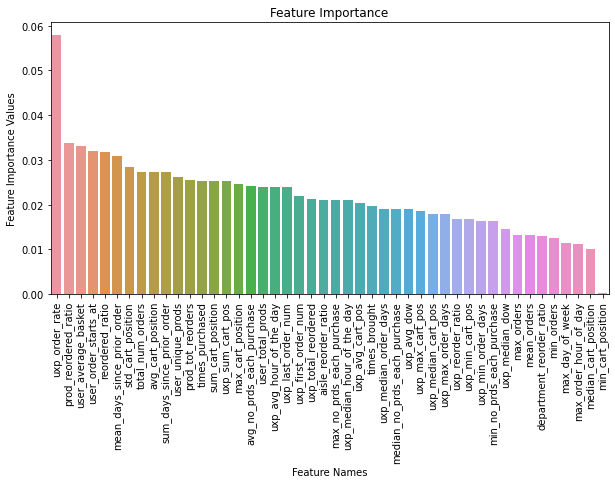

In [45]:
plt.figure(figsize = (10, 5))
ax = sns.barplot(x = feature_imp_names, y = feature_imp_values)
ax.set_xticklabels(labels = feature_imp_names, rotation = 90)
sns.set_palette(reversed(sns.color_palette("husl", 10)), 10)
plt.title('Feature Importance')
plt.xlabel('Feature Names')
plt.ylabel('Feature Importance Values')
plt.show()

# Logistic Regression

Hyper-Parameter Tuning

In [60]:
from sklearn.model_selection import RandomizedSearchCV

params = {'C' : [0.001,0.01,1,10] }

lr_model=LogisticRegression(penalty='l2',class_weight='balanced')
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [61]:
random_cfl=RandomizedSearchCV(lr_model,param_distributions={'C' : [0.001] },verbose=10,cv=4)
random_cfl

RandomizedSearchCV(cv=4, estimator=LogisticRegression(class_weight='balanced'),
                   param_distributions={'C': [0.001]}, verbose=10)

In [62]:
random_cfl.fit(X_train,y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4; 1/1] START C=0.001.....................................................
[CV 1/4; 1/1] END ......................C=0.001;, score=0.686 total time= 1.1min
[CV 2/4; 1/1] START C=0.001.....................................................
[CV 2/4; 1/1] END ......................C=0.001;, score=0.697 total time= 1.0min
[CV 3/4; 1/1] START C=0.001.....................................................
[CV 3/4; 1/1] END ......................C=0.001;, score=0.662 total time=  59.0s
[CV 4/4; 1/1] START C=0.001.....................................................
[CV 4/4; 1/1] END ......................C=0.001;, score=0.705 total time= 1.1min


RandomizedSearchCV(cv=4, estimator=LogisticRegression(class_weight='balanced'),
                   param_distributions={'C': [0.001]}, verbose=10)

In [64]:
# Best Paramaters
random_cfl.best_params_

{'C': 0.001}

In [65]:
# To get the best threshold for max F1 score

# Initializing the model
lr_model = LogisticRegression(C=0.001)
lr_model.fit(X_train, y_train)
thresholds = lr_model.predict_proba(X_test)

In [66]:
thresholds

array([[0.80199216, 0.19800784],
       [0.84919388, 0.15080612],
       [0.88307596, 0.11692404],
       ...,
       [0.79736138, 0.20263862],
       [0.74300295, 0.25699705],
       [0.9054568 , 0.0945432 ]])

In [67]:
# To check the mean and standard deviation of thresholds 
mean = np.mean(thresholds)
std = np.std(thresholds)

In [68]:
# To get the range of threshold values to calculate f1 score
print(mean)
print(std)
print(mean+2*std)
print(mean-2*std)

0.4999999999999999
0.3733676533611084
1.2467353067222167
-0.24673530672221688


In [69]:
# Taking np.arange(0,1,0.02) would take a long time to finish execution. An easier 
# way would be to use the spread of thresholds to determine the best threshold
threshold_values = np.arange(mean-2*std,mean+2*std,0.02)
f1_scores = []
for threshold in threshold_values:
    y_pred = (lr_model.predict_proba(X_test)[:, 1] >= threshold).astype('int')
    f1_scores.append(f1_score(y_test , y_pred))

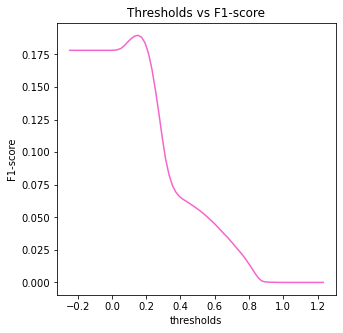

In [70]:
plt.figure(figsize=(5,5))
sns.lineplot(threshold_values , f1_scores)
plt.xlabel("thresholds")
plt.ylabel("F1-score")
plt.title("Thresholds vs F1-score")

plt.show()

In [71]:
print('Best threshold: ', threshold_values[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best threshold:  0.15326469327778292
Best F1-Score:  0.18968491310189398


In [72]:
# Taken from Facebook Recomendation system case study

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Model Evaluation

Train F1 Score: 0.18984651660875065
Validation F1 Score: 0.18978351166792126
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.92      0.75   1600774
           1       0.45      0.12      0.19    941625

    accuracy                           0.62   2542399
   macro avg       0.55      0.52      0.47   2542399
weighted avg       0.57      0.62      0.54   2542399

--------------------------------------------------


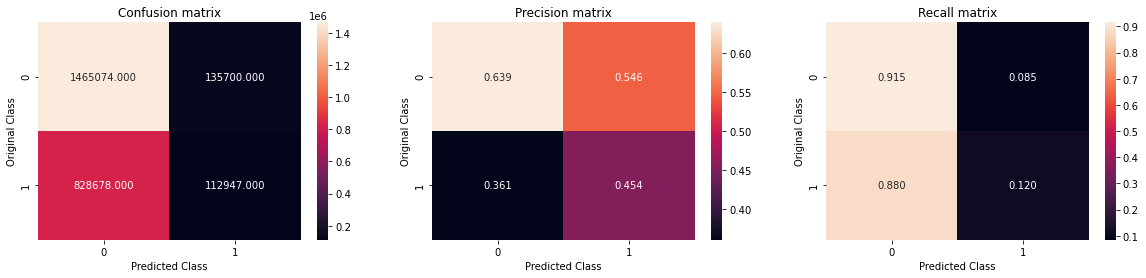

In [73]:
lr_model = LogisticRegression(C=0.001)
lr_model.fit(X_train, y_train)

train_pred_y = (lr_model.predict_proba(X_train)[:, 1] >= 0.15).astype('int')
test_pred_y = (lr_model.predict_proba(X_test)[:, 1] >= 0.15).astype('int')

f1_train = f1_score(train_pred_y, y_train)
f1_test = f1_score(test_pred_y, y_test)

print("Train F1 Score:", f1_train)
print("Validation F1 Score:", f1_test)
print("-"*50)
print(classification_report(test_pred_y, y_test))
print("-"*50)
plot_confusion_matrix(test_pred_y, y_test)